# Analysis of heterogeneous ABM - NO NETWORK

Assumes a well-mixed heterogeneous population in which agents communicate and observe behaviour of all other agents.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol as sobol_analyze
from SALib.test_functions import Ishigami
import random

/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_99764/619868074.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#from model import ConsumatModel
from model_heterogeneous_copy import ConsumatModel

In [3]:
#Import KDE models

kde_modeks = {
    'ccrdprs': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_ccrdprs.pkl'),
    'gvsrdcc': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_gvsrdcc.pkl'),
    'hincfel': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_hincfel.pkl'),
    'impenv': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_impenv.pkl'),
    'impfree': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_impfree.pkl'),
    'imprich': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_imprich.pkl'),
    'inctxff': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_inctxff.pkl'),
    'inprdsc': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_inprdsc.pkl'),
    'ipfrule': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_ipfrule.pkl'),
    'iplylfr': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_iplylfr.pkl'),
    'lkredcc': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_lkredcc.pkl'),
    'sclmeet': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_sclmeet.pkl'),
    'wrclmch': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_wrclmch.pkl'),
    'wrkctra': joblib.load('/Applications/UNI/Thesis/saved_kde/kde_wrkctra.pkl')
}

In [4]:
base_config = {
    'TP_percentage': 0.6,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_kde/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'num_agents': 1000, 
    'seed': 42  # Seed for reproducibility
}



In [5]:
def run_simulation(model, num_steps):
    # List to store True Price Adoption Rates
    adoption_rates = []

    # Run the model for a specified number of steps with tqdm for progress tracking
    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        # Calculate and append the current adoption rate to the list
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    # Retrieve collected data from the model's DataCollector
    model_data = model.datacollector.get_model_vars_dataframe()
    # Append the adoption rates to the DataFrame
    model_data['Adoption Rates'] = adoption_rates  # Ensure this matches how you collect data in DataCollector

    return model_data


In [6]:
model = ConsumatModel(base_config)
num_steps = 10
model_data = run_simulation(model, num_steps)
print(model_data)


Simulation Progress: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

   True_Price_Adoption_Rate  Average_Satisfaction  Average_Choice_Changes  \
0                       0.0              0.532918                   0.564   
1                       0.0              0.543383                   0.564   
2                       0.0              0.543383                   0.564   
3                      99.0              0.422288                   0.757   
4                      91.1              0.512990                   0.842   
5                      99.0              0.541955                   0.847   
6                      99.1              0.550228                   0.847   
7                      99.1              0.550255                   0.847   
8                      99.1              0.550255                   0.847   
9                      99.1              0.550255                   0.847   

   Average_Decision_Mode_Changes  Avg_F_Satisfaction  Avg_S_Satisfaction  \
0                          1.000            0.037458            0.912666   


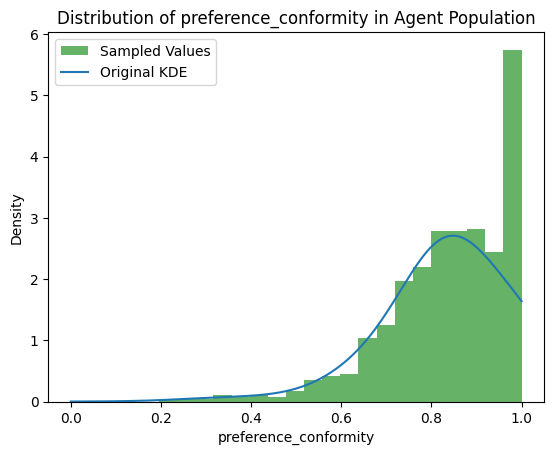

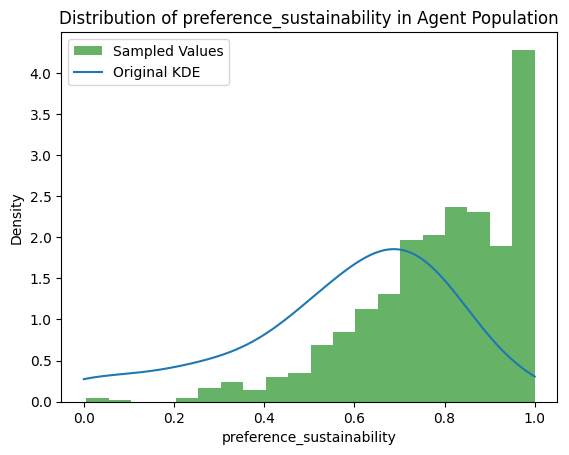

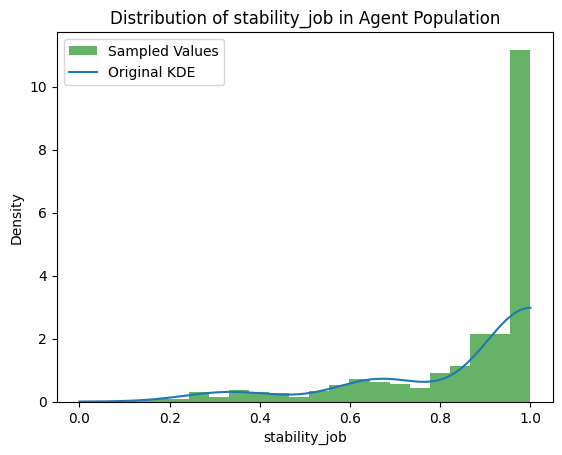

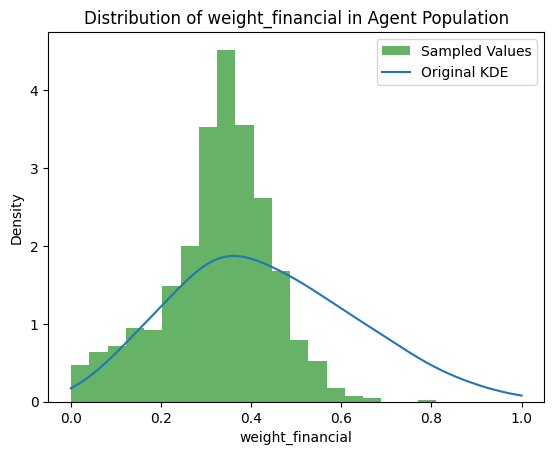

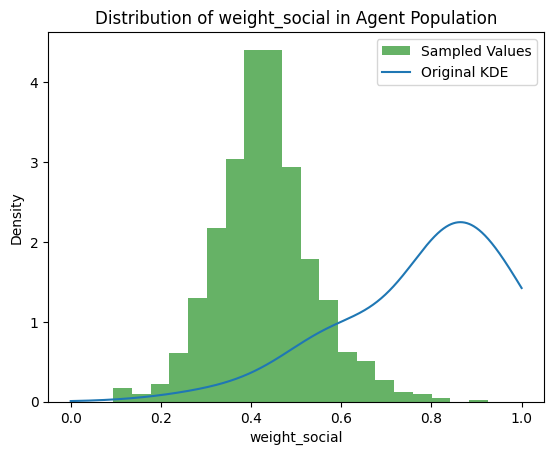

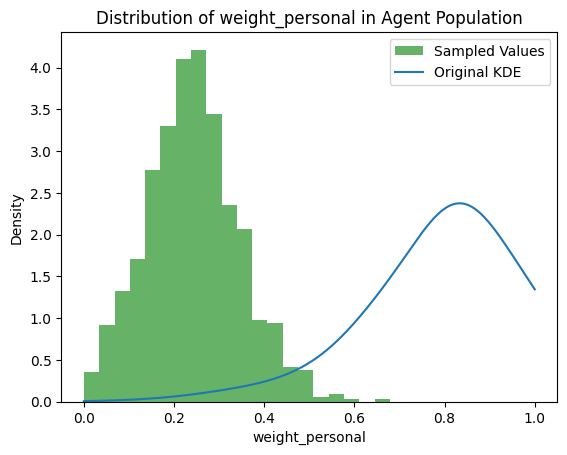

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def extract_attribute_values(model, attribute_name):
    return [getattr(agent, attribute_name) for agent in model.schedule.agents]

def plot_distributions(model, attribute_name, kde_model):
    values = extract_attribute_values(model, attribute_name)
    
    # Plot histogram of the sampled values
    plt.hist(values, bins=20, density=True, alpha=0.6, color='g', label='Sampled Values')

    # Plot the original KDE
    x_d = np.linspace(0, 1, 1000).reshape(-1, 1)
    logprob = kde_model.score_samples(x_d)
    pdf = np.exp(logprob)
    plt.plot(x_d, pdf, '-', label='Original KDE')

    plt.title(f'Distribution of {attribute_name} in Agent Population')
    plt.xlabel(attribute_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Example usage for different attributes
plot_distributions(model, 'preference_conformity', model.kde_models['iplylfr'])
plot_distributions(model, 'preference_sustainability', model.kde_models['ccrdprs'])
plot_distributions(model, 'stability_job', model.kde_models['wrkctra'])
plot_distributions(model, 'weight_financial', model.kde_models['imprich'])
plot_distributions(model, 'weight_social', model.kde_models['sclmeet'])
plot_distributions(model, 'weight_personal', model.kde_models['impenv'])


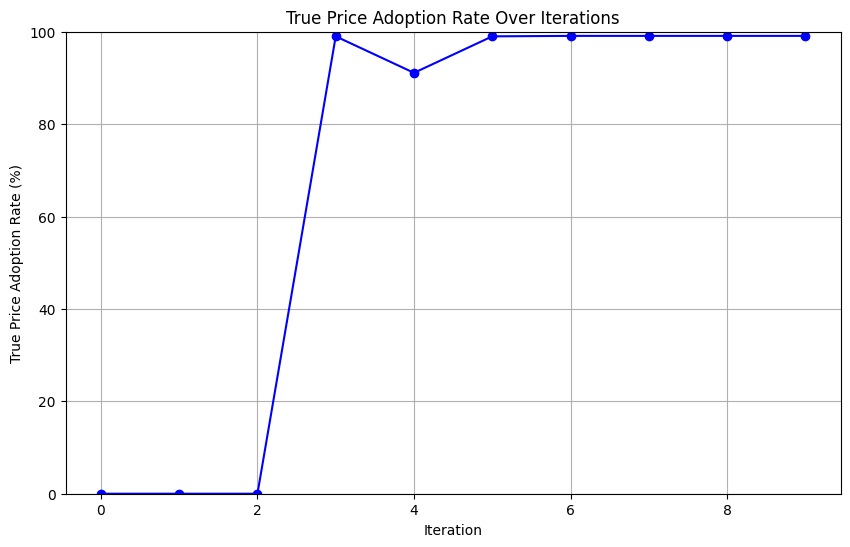

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(model_data['Adoption Rates'], marker='o', color='b')
plt.title('True Price Adoption Rate Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('True Price Adoption Rate (%)')
plt.ylim(0,100)
plt.grid(True)
plt.show()

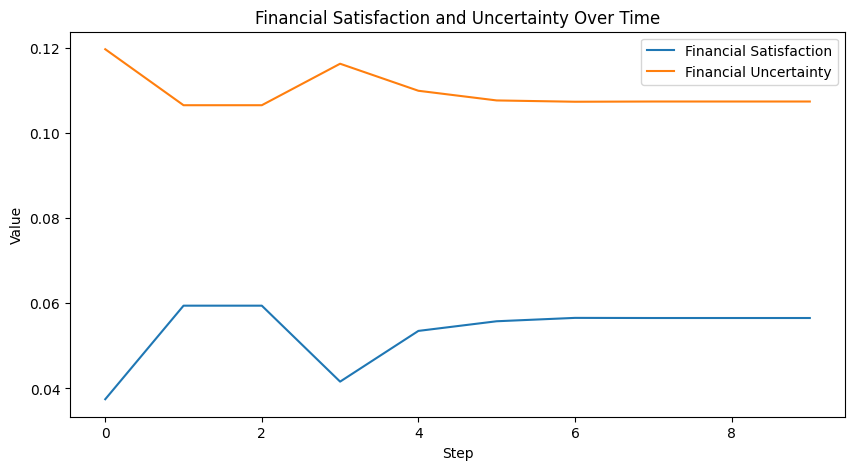

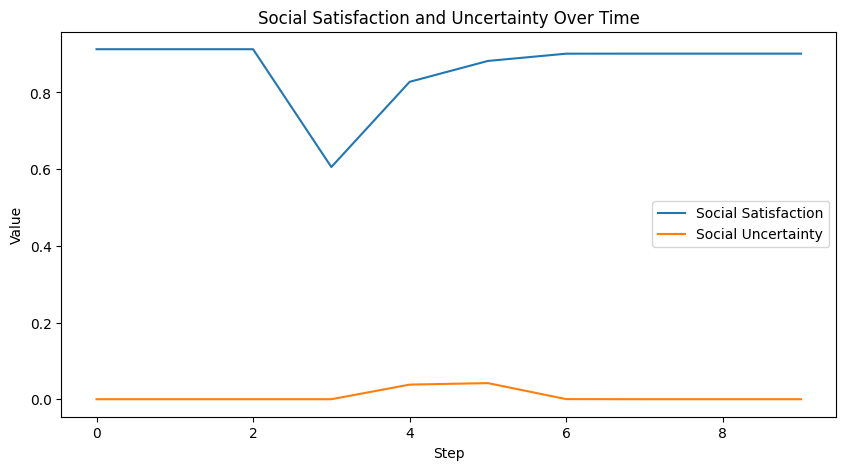

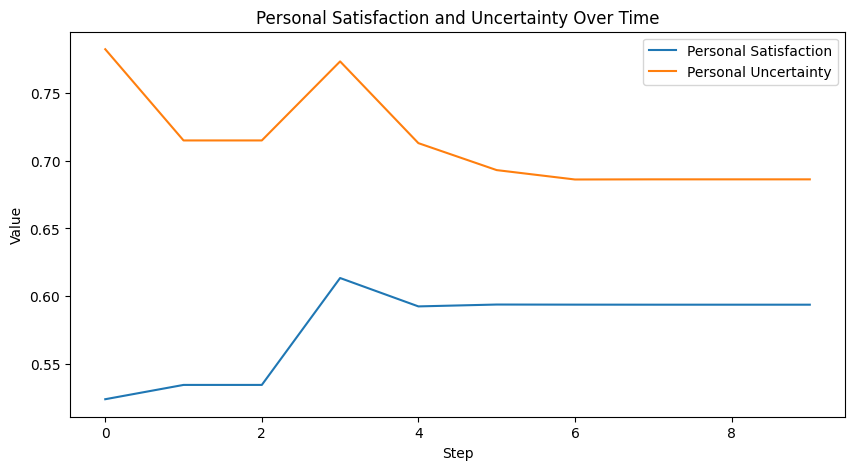

In [10]:
import matplotlib.pyplot as plt

# Plot financial satisfaction and uncertainty
plt.figure(figsize=(10, 5))
plt.plot(model_data['Avg_F_Satisfaction'], label='Financial Satisfaction')
plt.plot(model_data['Avg_F_Uncertainty'], label='Financial Uncertainty')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.title('Financial Satisfaction and Uncertainty Over Time')
plt.show()

# Plot social satisfaction and uncertainty
plt.figure(figsize=(10, 5))
plt.plot(model_data['Avg_S_Satisfaction'], label='Social Satisfaction')
plt.plot(model_data['Avg_S_Uncertainty'], label='Social Uncertainty')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.title('Social Satisfaction and Uncertainty Over Time')
plt.show()

# Plot personal satisfaction and uncertainty
plt.figure(figsize=(10, 5))
plt.plot(model_data['Avg_P_Satisfaction'], label='Personal Satisfaction')
plt.plot(model_data['Avg_P_Uncertainty'], label='Personal Uncertainty')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.title('Personal Satisfaction and Uncertainty Over Time')
plt.show()



How many agents choose each strategy per step:

      Repeat  Imitate  Deliberate  Social_Compare
Step                                             
1        422       10         568               0
2        777        3         220               0
3        777        3         220               0
4        291        4         705               0
5        632        5         363               0
6        714        5         281               0
7        744        5         251               0
8        744        4         252               0
9        744        4         252               0
10       744        4         252               0


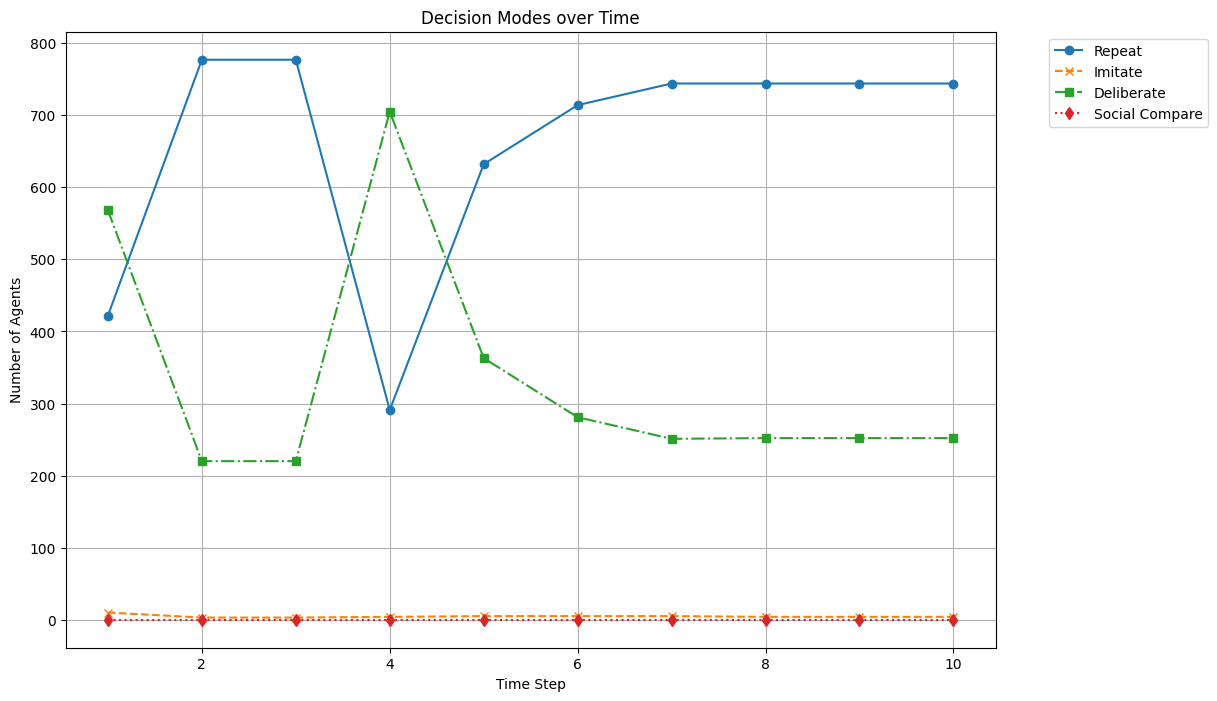

In [11]:
model_data = model.datacollector.get_agent_vars_dataframe()
decision_modes_count = model_data.groupby('Step').sum()[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']]
print(decision_modes_count)

# Plot the decision modes count over time
plt.figure(figsize=(12, 8))
plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label='Repeat', linestyle='-', marker='o')
plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label='Imitate', linestyle='--', marker='x')
plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label='Deliberate', linestyle='-.', marker='s')
plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label='Social Compare', linestyle=':', marker='d')
plt.title('Decision Modes over Time')
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


### Distribution of agent attributes:

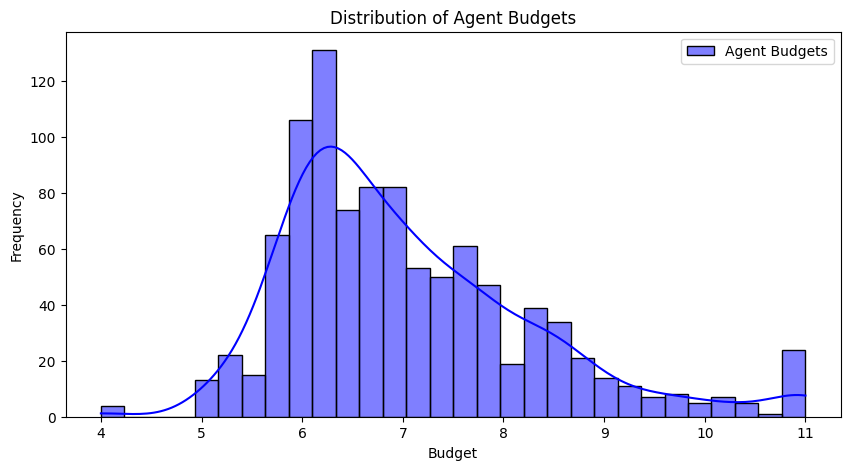

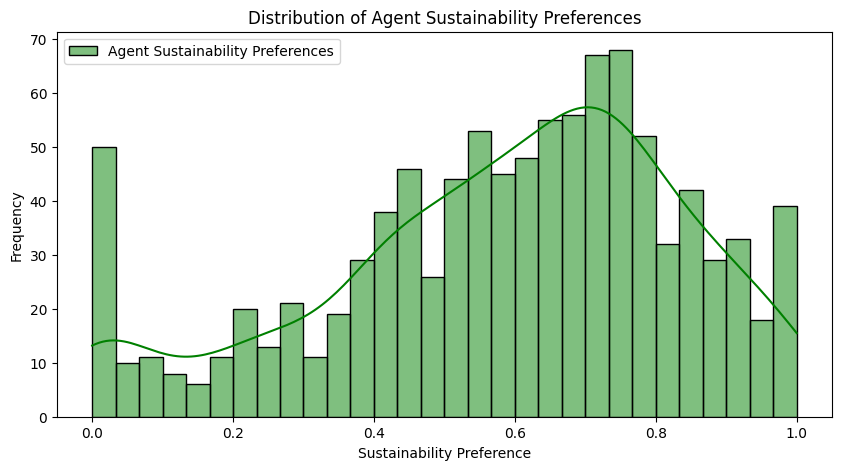

In [11]:
# Collect agent attributes
agent_budgets = [agent.budget for agent in model.agents]
agent_sustainability_preferences = [agent.preference_sustainability for agent in model.agents]

# Visualization code here
# Plot for Budget Distribution
plt.figure(figsize=(10, 5))
sns.histplot(agent_budgets, bins=30, kde=True, color='blue', label='Agent Budgets')
plt.title('Distribution of Agent Budgets')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot for Sustainability Preferences Distribution
plt.figure(figsize=(10, 5))
sns.histplot(agent_sustainability_preferences, bins=30, kde=True, color='green', label='Agent Sustainability Preferences')
plt.title('Distribution of Agent Sustainability Preferences')
plt.xlabel('Sustainability Preference')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Multiple runs of the same model:

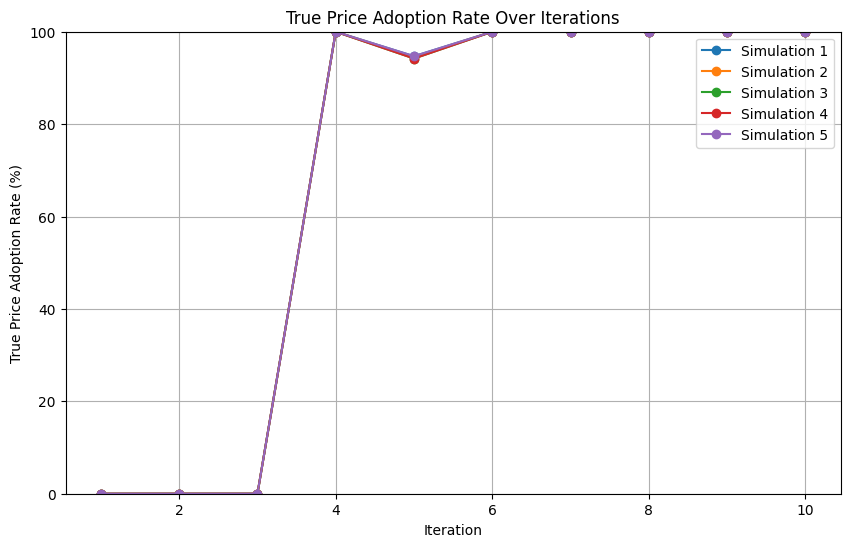

In [ ]:

base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'num_agents': 1000, 
    'seed': 42  # Seed for reproducibility
}

# Number of simulations
num_simulations = 5

# Number of steps per simulation
num_steps = 10

# Function to run the simulation and return adoption rates over steps
def run_simulation(model, num_steps):
    adoption_rates = []
    for _ in range(num_steps):
        model.step()
        model_data = model.datacollector.get_model_vars_dataframe()
        adoption_rate = model_data['True_Price_Adoption_Rate'].iloc[-1]
        adoption_rates.append(adoption_rate)
    return adoption_rates

# Initialize a figure
plt.figure(figsize=(10, 6))

# Loop over the number of simulations
for simulation in range(num_simulations):
    # Initialize your model
    model = ConsumatModel(base_config)
    
    # Run the model for a specified number of steps and collect adoption rates
    adoption_rates = run_simulation(model, num_steps)
    
    # Plotting the results for the current simulation
    plt.plot(range(1, num_steps + 1), adoption_rates, marker='o', label=f'Simulation {simulation + 1}')

# Finalizing the plot
plt.title('True Price Adoption Rate Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('True Price Adoption Rate (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()


### Vary True Price percentage

Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


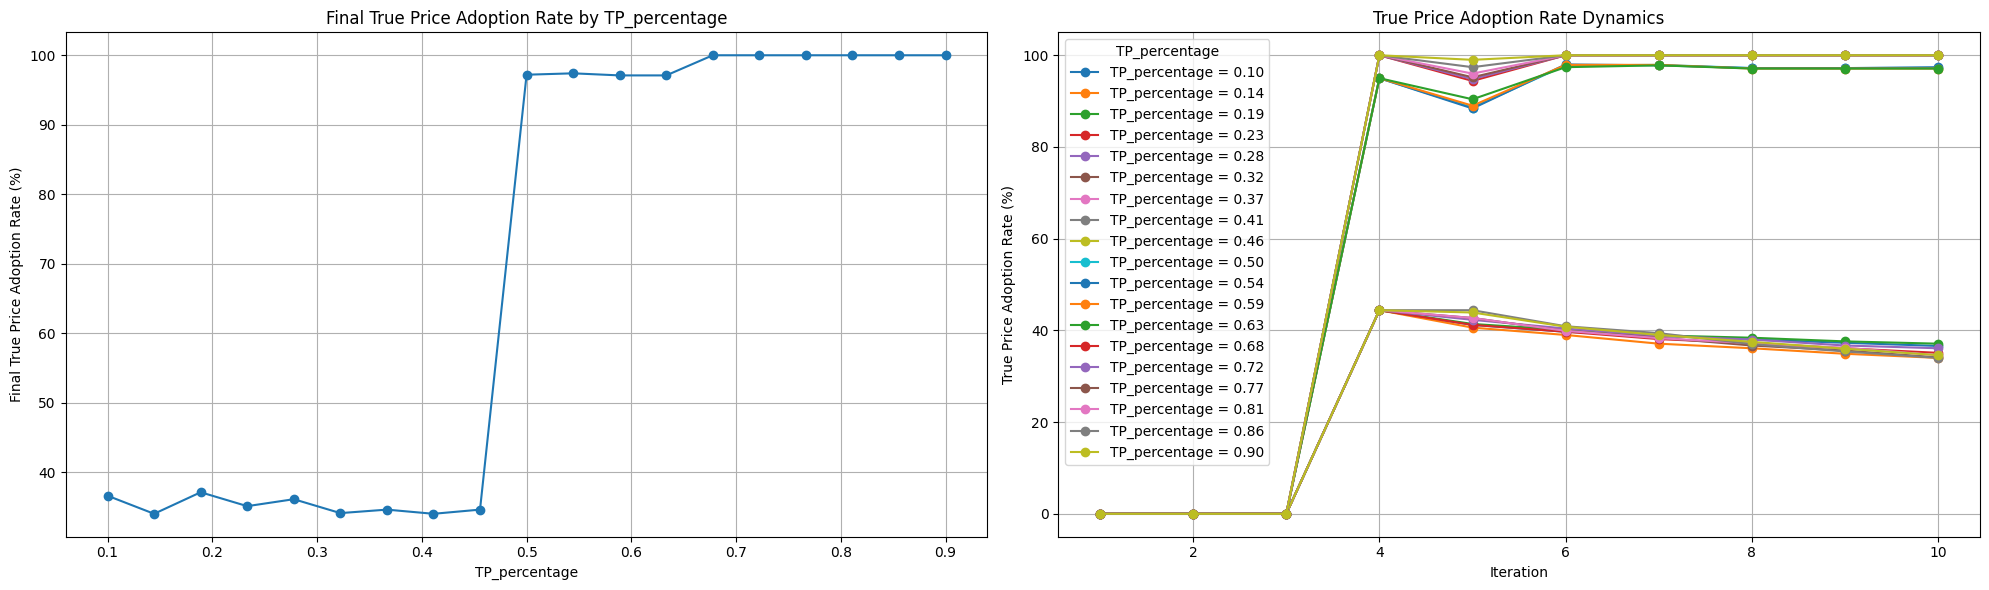

In [13]:
# Define TP percentages and simulation steps
tp_percentages = np.linspace(0.1, 0.9, 19)  # From 10% to 90%
num_steps = 10

# Prepare figure for plotting
plt.figure(figsize=(20, 6))

# Store final adoption rates and all adoption rates for plotting
final_adoption_rates = []
all_adoption_rates = []

# Run the simulation for each TP_percentage
for tp_percentage in tp_percentages:
    base_config['TP_percentage'] = tp_percentage
    model = ConsumatModel(base_config)
    model_data = run_simulation(model, num_steps)
    
    # Collect data for the plots
    final_adoption_rates.append(model_data['Adoption Rates'].iloc[-1])
    all_adoption_rates.append(model_data['Adoption Rates'].values)

# Plot 1: Final Adoption Rate by TP_percentage
plt.subplot(1, 2, 1)
plt.plot(tp_percentages, final_adoption_rates, marker='o')
plt.title('Final True Price Adoption Rate by TP_percentage')
plt.xlabel('TP_percentage')
plt.ylabel('Final True Price Adoption Rate (%)')
plt.grid(True)

# Plot 2: Adoption Rate Dynamics by TP_percentage
plt.subplot(1, 2, 2)
for i, rates in enumerate(all_adoption_rates):
    plt.plot(range(1, num_steps + 1), rates, label=f'TP_percentage = {tp_percentages[i]:.2f}', marker='o')

plt.title('True Price Adoption Rate Dynamics')
plt.xlabel('Iteration')
plt.ylabel('True Price Adoption Rate (%)')
plt.legend(title='TP_percentage')
plt.grid(True)

plt.tight_layout()
plt.show()

Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


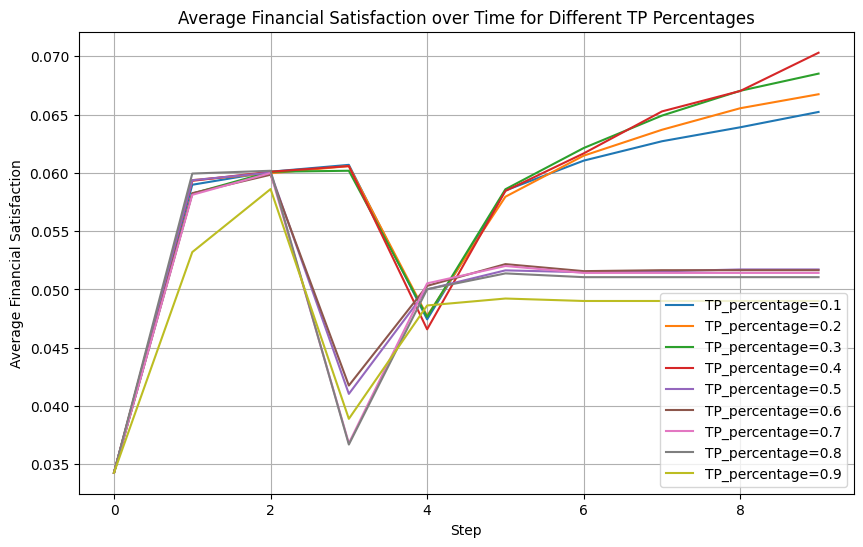

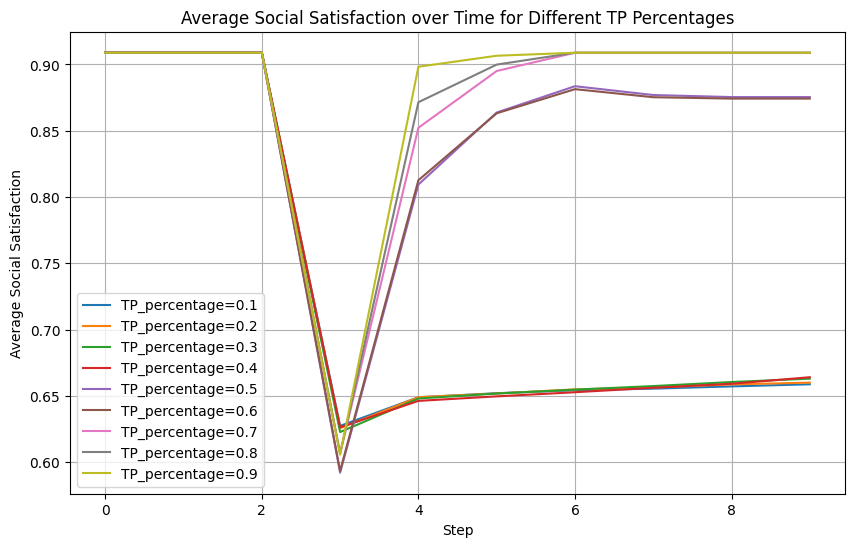

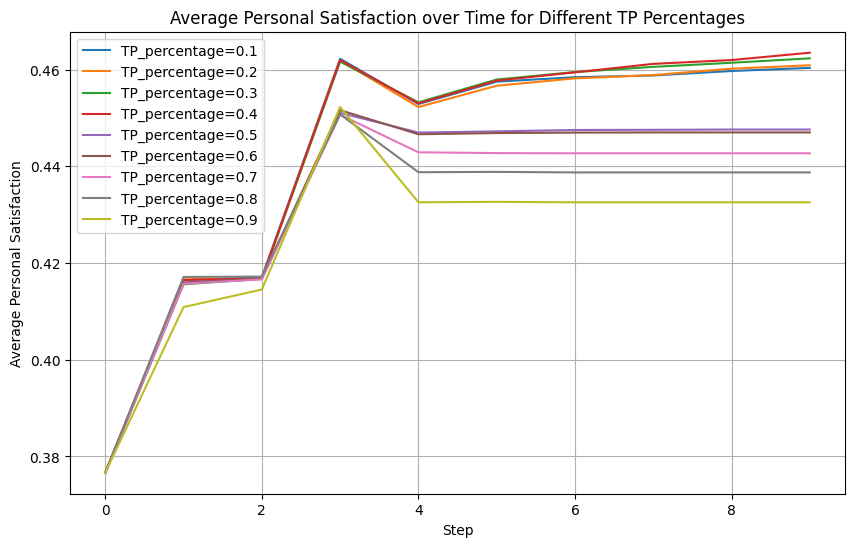

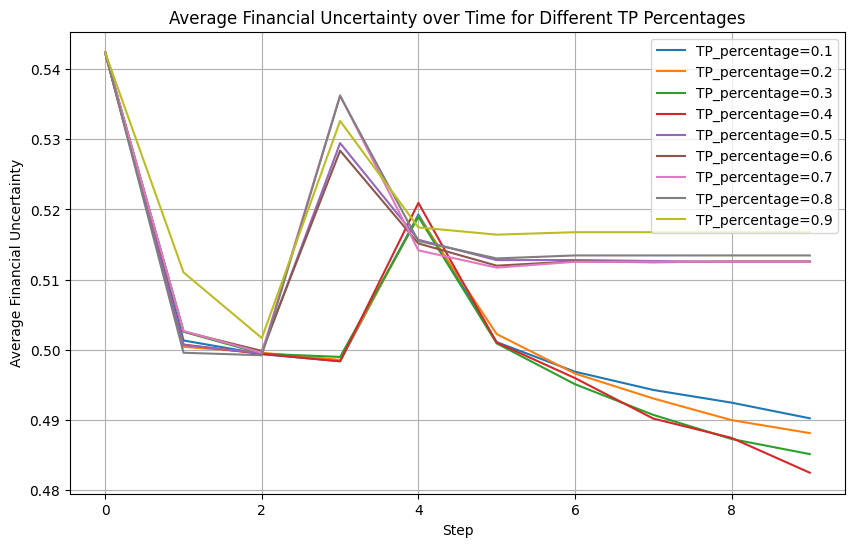

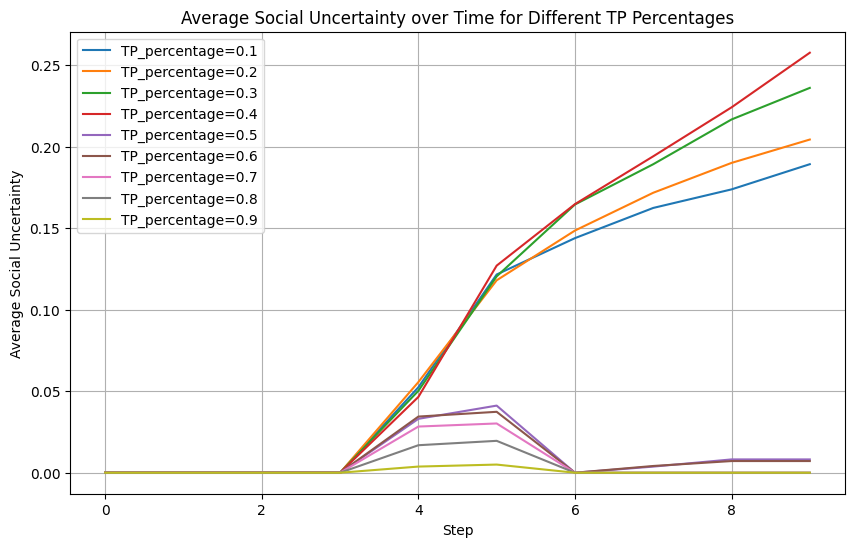

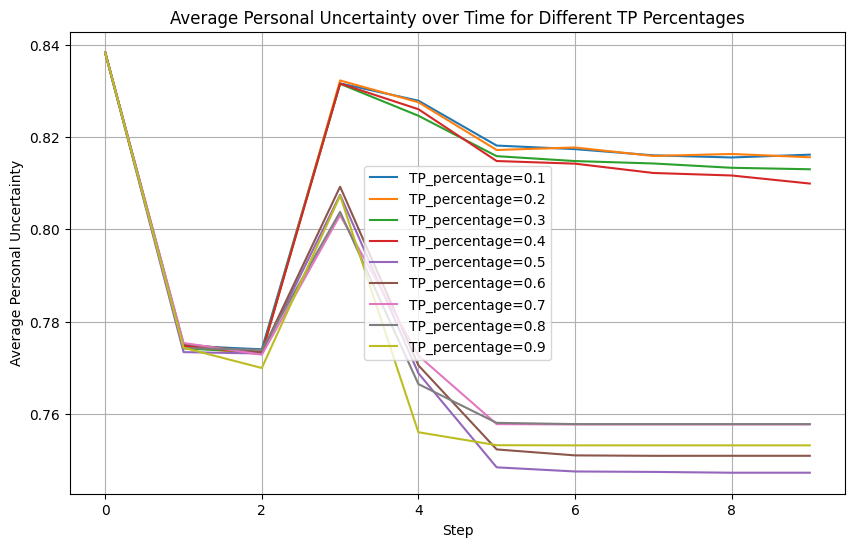

In [14]:


def collect_simulation_data(model, num_steps):
    # List to store collected data
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    # Run the model for a specified number of steps with tqdm for progress tracking
    for step in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        # Collect data from the model
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    # Convert the collected data to a DataFrame
    model_data = pd.DataFrame(collected_data)

    return model_data

tp_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_steps = 10
all_results = {}

for tp in tp_percentages:
    base_config['TP_percentage'] = tp
    model = ConsumatModel(base_config)
    model_data = collect_simulation_data(model, num_steps)
    all_results[tp] = model_data

def plot_metric(all_results, metric, ylabel):
    plt.figure(figsize=(10, 6))
    for tp, data in all_results.items():
        plt.plot(data['Step'], data[metric], label=f'TP_percentage={tp}')
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} over Time for Different TP Percentages')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting
plot_metric(all_results, 'Avg_F_Satisfaction', 'Average Financial Satisfaction')
plot_metric(all_results, 'Avg_S_Satisfaction', 'Average Social Satisfaction')
plot_metric(all_results, 'Avg_P_Satisfaction', 'Average Personal Satisfaction')
plot_metric(all_results, 'Avg_F_Uncertainty', 'Average Financial Uncertainty')
plot_metric(all_results, 'Avg_S_Uncertainty', 'Average Social Uncertainty')
plot_metric(all_results, 'Avg_P_Uncertainty', 'Average Personal Uncertainty')


## Global Sensitivity Analysis

Sobol indices

Saltelli sampling


In [17]:

# Base configuration
base_config = {
    'TP_percentage': 0.8,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_kde/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'num_agents': 1000, 
    'seed': 42  # Seed for reproducibility
}

# Problem definition
problem = {
    'num_vars': 5,
    'names': ['TP_percentage',
              'product_price_low', 'product_price_high', 'min_increase_percentage',
              'max_increase_percentage'],
    'bounds': [
        [0.4, 0.9],   # TP_percentage
        [4, 6],     # product_price_low
        [9, 11],    # product_price_high
        [2, 6],     # min_increase_percentage
        [8, 12],    # max_increase_percentage
    ]
}

# Function to run the simulation
def run_simulation(params, num_steps=10, seed=42):
    config = base_config.copy()
    config.update({
        'TP_percentage': params[0],
        'product_price_range': (params[1], params[2]),
        'min_increase_percentage': params[3],
        'max_increase_percentage': params[4],
        'seed': seed 
    })
    
    np.random.seed(seed)
    random.seed(seed)
    model = ConsumatModel(config)
    
    for _ in range(num_steps):
        model.step()
    
    model_data = model.datacollector.get_model_vars_dataframe()
    final_adoption_rate = model_data['True_Price_Adoption_Rate'].iloc[-1]
    avg_satisfaction = model_data['Average_Satisfaction'].iloc[-1]
    avg_choice_changes = model_data['Average_Choice_Changes'].iloc[-1]
    avg_decision_mode_changes = model_data['Average_Decision_Mode_Changes'].iloc[-1]
    
    return final_adoption_rate, avg_satisfaction, avg_choice_changes, avg_decision_mode_changes

# Sensitivity analysis function
def run_sensitivity_analysis(base_config, problem, num_steps=10, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    param_values = sobol_sample.sample(problem, 16, calc_second_order=True)
    
    Y_adoption = []
    Y_satisfaction = []
    Y_choice_changes = []
    Y_decision_mode_changes = []

    for params in tqdm(param_values, desc='Running Simulations'):
        adoption_rate, avg_satisfaction, avg_choice_changes, avg_decision_mode_changes = run_simulation(params, num_steps, seed)
        Y_adoption.append(adoption_rate)
        Y_satisfaction.append(avg_satisfaction)
        Y_choice_changes.append(avg_choice_changes)
        Y_decision_mode_changes.append(avg_decision_mode_changes)

    Y_adoption = np.array(Y_adoption)
    Y_satisfaction = np.array(Y_satisfaction)
    Y_choice_changes = np.array(Y_choice_changes)
    Y_decision_mode_changes = np.array(Y_decision_mode_changes)

    Si_adoption = sobol_analyze.analyze(problem, Y_adoption, seed=seed)
    Si_satisfaction = sobol_analyze.analyze(problem, Y_satisfaction, seed=seed)
    Si_choice_changes = sobol_analyze.analyze(problem, Y_choice_changes, seed=seed)
    Si_decision_mode_changes = sobol_analyze.analyze(problem, Y_decision_mode_changes, seed=seed)
    
    return Si_adoption, Si_satisfaction, Si_choice_changes, Si_decision_mode_changes


# Run sensitivity analysis
Si_adoption, Si_satisfaction, Si_choice_changes, Si_decision_mode_changes = run_sensitivity_analysis(base_config, problem)
print("First order Sobol indices for Adoption Rate:", Si_adoption['S1'])
print("Total order Sobol indices for Adoption Rate:", Si_adoption['ST'])
print("First order Sobol indices for Satisfaction:", Si_satisfaction['S1'])
print("Total order Sobol indices for Satisfaction:", Si_satisfaction['ST'])
print("First order Sobol indices for Choice Changes:", Si_choice_changes['S1'])
print("Total order Sobol indices for Choice Changes:", Si_choice_changes['ST'])
print("First order Sobol indices for Decision Mode Changes:", Si_decision_mode_changes['S1'])
print("Total order Sobol indices for Decision Mode Changes:", Si_decision_mode_changes['ST'])


Running Simulations: 100%|██████████| 192/192 [14:21<00:00,  4.49s/it]

First order Sobol indices for Adoption Rate: [ 6.56073525e-01 -2.98257806e-04 -1.57647109e-02  3.55871575e-04
 -7.24615807e-03]
Total order Sobol indices for Adoption Rate: [4.84782649e-01 5.99913560e-05 6.48656537e-04 1.02641461e-04
 2.10438429e-04]
First order Sobol indices for Satisfaction: [ 0.55743282 -0.01005804  0.00498957  0.00685919  0.00439879]
Total order Sobol indices for Satisfaction: [0.5277393  0.00098233 0.00396403 0.00276155 0.00059577]
First order Sobol indices for Choice Changes: [ 0.46555108  0.07043096 -0.03332781 -0.09737569 -0.03290013]
Total order Sobol indices for Choice Changes: [0.23864004 0.0470859  0.02363287 0.04124429 0.02098849]
First order Sobol indices for Decision Mode Changes: [ 0.26379473  0.1027711   0.00785703 -0.05900364 -0.05495398]
Total order Sobol indices for Decision Mode Changes: [0.17272477 0.03261189 0.08163774 0.0297732  0.03325104]


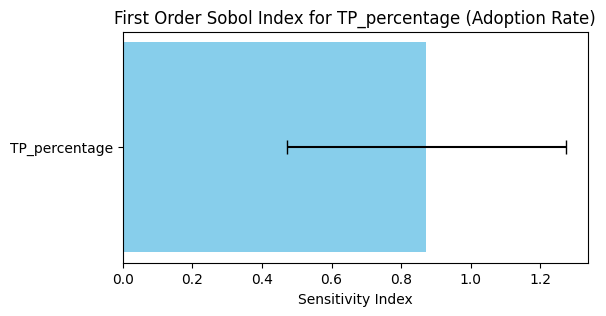

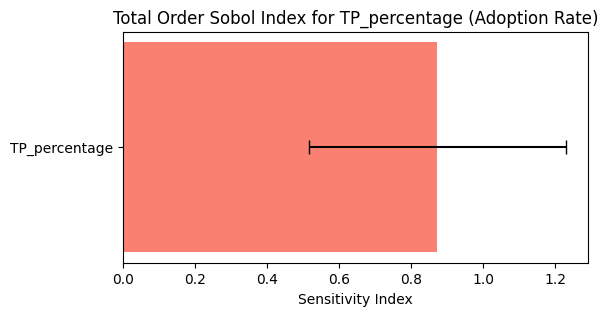

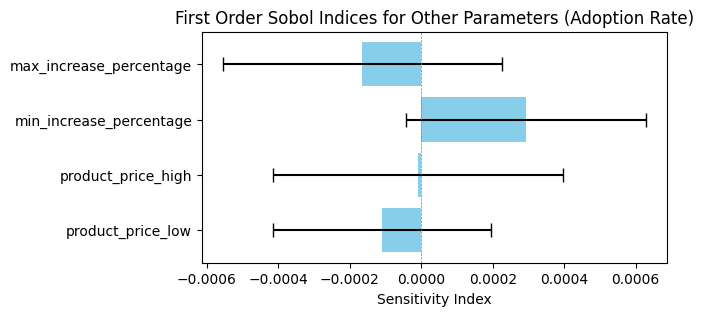

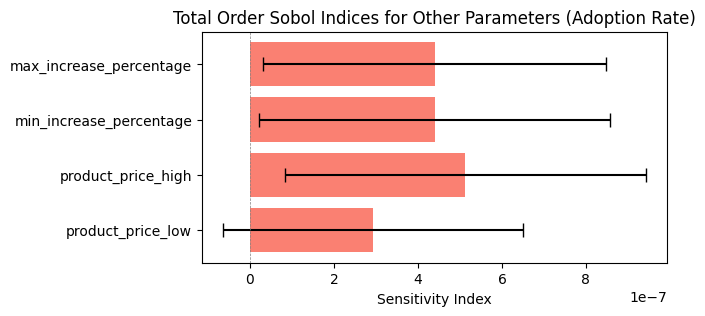

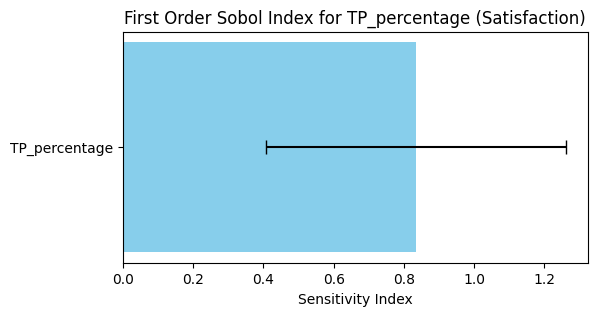

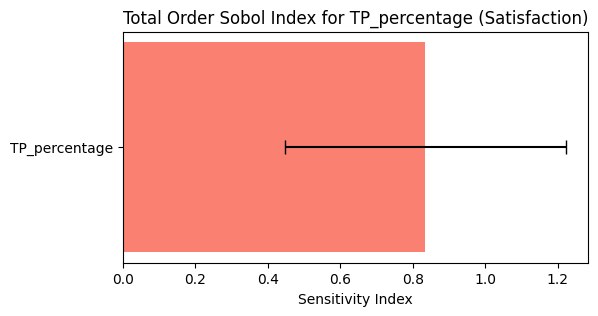

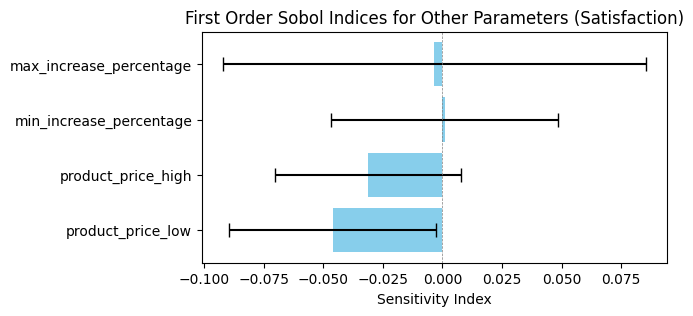

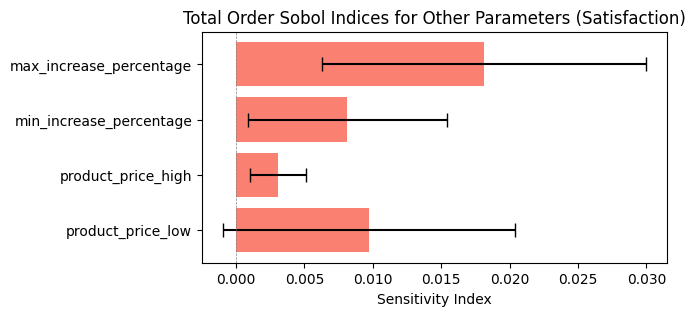

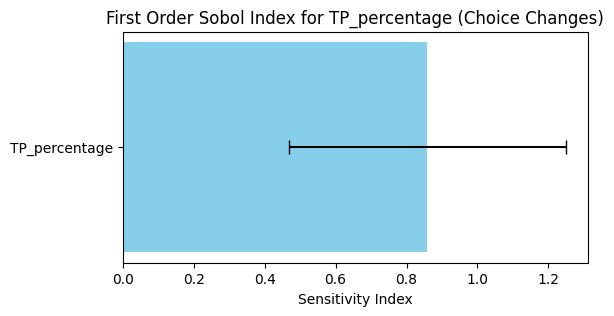

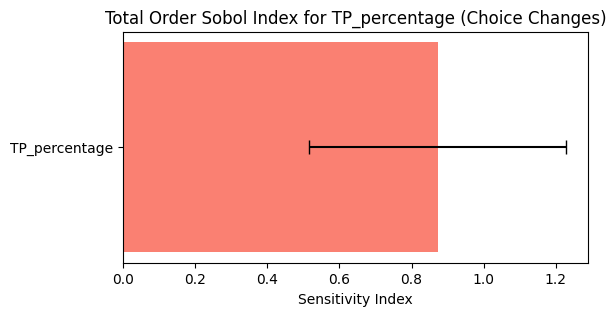

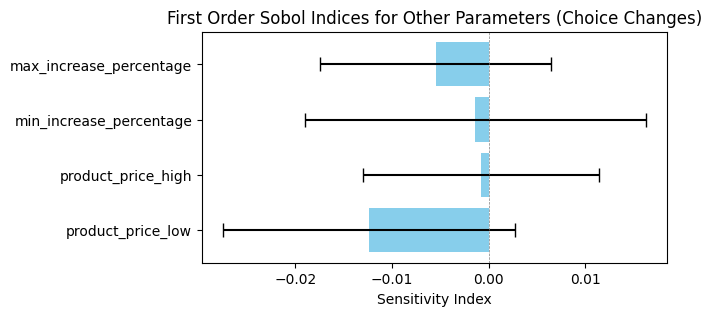

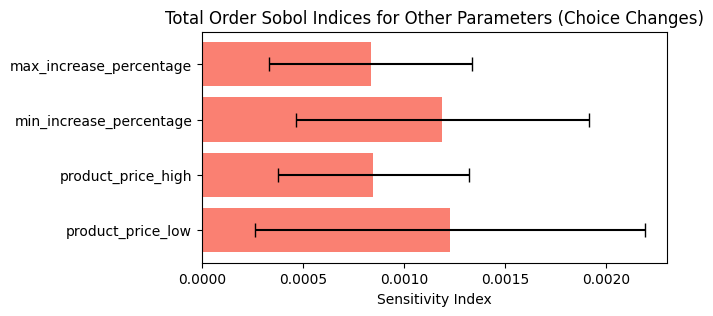

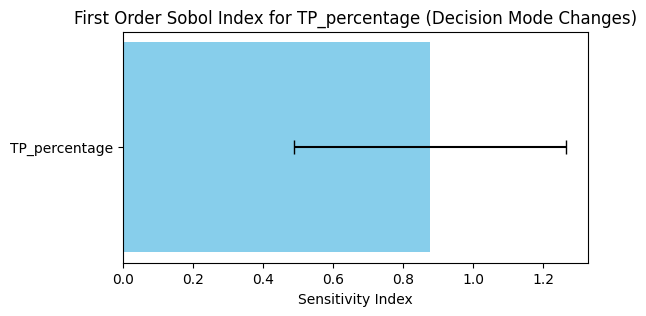

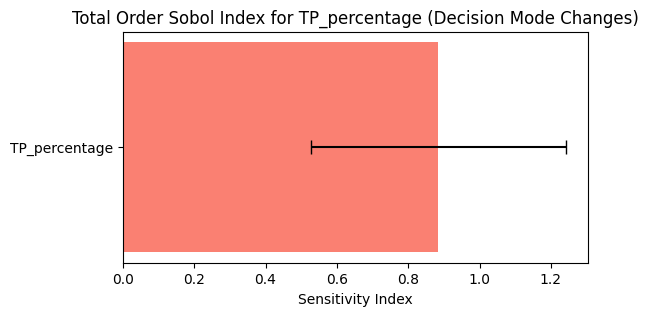

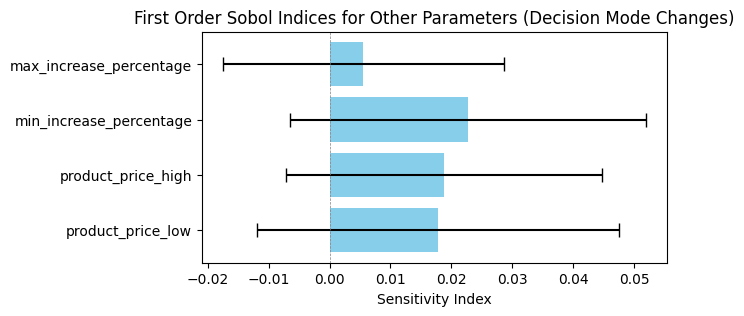

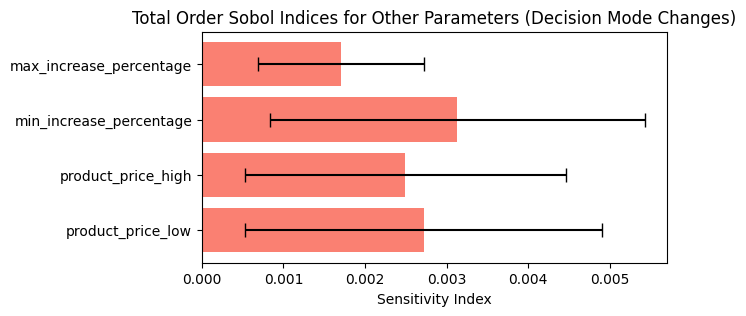

In [ ]:


# List of parameter names
param_names = ['TP_percentage', 'product_price_low', 'product_price_high', 'min_increase_percentage', 'max_increase_percentage']

# Define the Sobol indices from the sensitivity analysis
sobol_results = {
    'Adoption Rate': Si_adoption,
    'Satisfaction': Si_satisfaction,
    'Choice Changes': Si_choice_changes,
    'Decision Mode Changes': Si_decision_mode_changes
}

# Function to plot Sobol indices separately for TP_percentage and other parameters
def plot_sobol_indices(results, metric_name):
    Si = results[metric_name]
    
    # Plot for TP_percentage
    plt.figure(figsize=(6, 3))
    plt.barh(['TP_percentage'], Si['S1'][0], xerr=Si['S1_conf'][0], align='center', color='skyblue', ecolor='black', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    plt.title(f'First Order Sobol Index for TP_percentage ({metric_name})')
    plt.xlabel('Sensitivity Index')
    plt.show()
    
    plt.figure(figsize=(6, 3))
    plt.barh(['TP_percentage'], Si['ST'][0], xerr=Si['ST_conf'][0], align='center', color='salmon', ecolor='black', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    plt.title(f'Total Order Sobol Index for TP_percentage ({metric_name})')
    plt.xlabel('Sensitivity Index')
    plt.show()

    # Plot for other parameters
    plt.figure(figsize=(6, 3))
    plt.barh(param_names[1:], Si['S1'][1:], xerr=Si['S1_conf'][1:], align='center', color='skyblue', ecolor='black', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    plt.title(f'First Order Sobol Indices for Other Parameters ({metric_name})')
    plt.xlabel('Sensitivity Index')
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.barh(param_names[1:], Si['ST'][1:], xerr=Si['ST_conf'][1:], align='center', color='salmon', ecolor='black', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    plt.title(f'Total Order Sobol Indices for Other Parameters ({metric_name})')
    plt.xlabel('Sensitivity Index')
    plt.show()

# Plotting Sobol indices for each metric
for metric in sobol_results:
    plot_sobol_indices(sobol_results, metric)


In [19]:
from SALib.analyze import sobol
# Base configuration for the ConsumatModel
base_config = {
    'TP_percentage': 0.6,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_kde/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'num_agents': 1000,
    'seed': 42  # Seed for reproducibility
}

# Your existing model simulation function
def run_simulation(model, num_steps):
    adoption_rates = []
    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)
    model_data = model.datacollector.get_model_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates
    return model_data

# Define the model function for sensitivity analysis
def model_function(params):
    TP_percentage, product_price_low, product_price_high, min_increase_percentage, max_increase_percentage = params
    config = base_config.copy()
    config.update({
        'TP_percentage': TP_percentage,
        'product_price_range': (product_price_low, product_price_high),
        'min_increase_percentage': min_increase_percentage,
        'max_increase_percentage': max_increase_percentage,
    })
    model = ConsumatModel(config)
    num_steps = 10
    model_data = run_simulation(model, num_steps)
    mean_adoption_rate = model_data['Adoption Rates'].mean()
    return mean_adoption_rate

# Problem definition
problem = {
    'num_vars': 5,
    'names': ['TP_percentage', 'product_price_low', 'product_price_high', 'min_increase_percentage', 'max_increase_percentage'],
    'bounds': [
        [0.4, 0.9],   # TP_percentage
        [4, 6],       # product_price_low
        [9, 11],      # product_price_high
        [2, 6],       # min_increase_percentage
        [8, 12],      # max_increase_percentage
    ]
}

# Generate samples using Saltelli's method
param_values = saltelli.sample(problem, 16)  # Adjusted sample size

# Run the model function for each sample
Y = np.array([model_function(params) for params in param_values])

# Perform the Sobol sensitivity analysis
Si = sobol.analyze(problem, Y)

# Print the Sobol indices
print("First order indices:", Si['S1'])
print("Total order indices:", Si['ST'])
print("Second order indices:", Si['S2'])


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_99764/3434229429.py:58: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16)  # Adjusted sample size
Simulation Progress: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

First order indices: [ 1.17565771  0.01333888  0.00477299 -0.00221629  0.00220191]
Total order indices: [1.18586515e+00 6.07485807e-03 6.85265403e-04 1.06182774e-04
 1.05527128e-04]
Second order indices: [[        nan -0.04567427 -0.00839121  0.00716251 -0.00180872]
 [        nan         nan -0.0037896  -0.00376532 -0.00381176]
 [        nan         nan         nan -0.00119355 -0.00118524]
 [        nan         nan         nan         nan  0.00042863]
 [        nan         nan         nan         nan         nan]]
